In [1]:
%matplotlib inline
from __future__ import division
import datetime
import numpy as np
import time
import matplotlib.pyplot as plt
import random
import time
import scipy
from scipy import optimize, signal
import pandas as pd
from collections import Counter, defaultdict
from itertools import count
from tqdm import *
import copy
from defenitions import *

large_number = 9999999999999999.9 # float('inf')*0 = nan! so use large number


In [2]:
trange

<function tqdm._tqdm.trange>

In [3]:
def cost_d(x,s,definitions):
    """Return a float or integer"""
    # Pump power consumption - Power output of the turbine per time step and error state 
    power_con = definitions['pump_dict'][x][(s)][1]-definitions['Power_table_det'][s[0]]
    if power_con >= 0:
        return power_con*definitions['Tariff'][s[0]]*int(definitions['Time_step'][:-1])/60
    else:
        return power_con*int(definitions['Time_step'][:-1])*5.5/60 # Export price
    

def new_state_d(x,s,definitions):
    """Return a tuple of the state"""
    
    
    return (s[0]+1, definitions['pump_dict'][x][(s)][0])
    

def val_T(s,settings):
    """Return a float or int"""
    if s[1] < settings['Initial state'][1]:
        return large_number
    else:
        return 0

In [4]:
def cost(x,s,definitions):
    """Return a float or integer"""
  
     
    # Pump power consumption - Power output of the turbine per time step and error state 
    power_con = definitions['pump_dict'][x][(s[:-1])][1]-definitions['Power_table'][s[0]][s[2]]
    
    if power_con >= 0:
        return power_con*definitions['Tariff'][s[0]]*int(definitions['Time_step'][:-1])/60
    else:
        return power_con*int(definitions['Time_step'][:-1])*5.5/60 # Export price
    

def new_state(x,s,definitions):
    """Return a tuple o fthe state"""

    return (s[0]+1, definitions['pump_dict'][x][(s[:-1])][0], s[2])
    

def val_T(s,settings):
    """Return a float or int"""
    if s[1] < settings['Initial state'][1]:
        return large_number
    else:
        return 0
    
def val_T2(s,settings):
    """Return a float or int"""
    return s[1]*314*8


In [5]:
def cost_from_schedule(Initial_fill,schedule,pump_obj,pipe_obj,tank_obj,turbine_power,base_demand,water_demand,Time_step,Tariff):
    """
    Computes the actual energy consumption and operating cost of a schedule
    
    Returns
    -------
    cost
    """
    Cost = 0
    state = Initial_fill
    for t, P_t in enumerate(turbine_power):
        q, P_p = flowrate_gen_real(schedule[t],pump_obj,pipe_obj,tank_obj,state)
        
        state = state+(q - base_demand*water_demand[t] )/tank_obj.Area
        
        Power_balance = P_p - P_t
        Cost += cost_from_power(Tariff[t],Power_balance,Time_step) 
        
    return Cost , state# in p

In [21]:
results = pd.DataFrame(columns=('day','h','schedule','cost_sim'))
results

Empty DataFrame
Columns: [day, h, schedule, cost_sim]
Index: []

In [22]:
for h in trange(0,400,50): 
    next_day = 400
    J = 11
    Time_step = '30T'  
    turb = Enercon # Vestas # Enercon # EWT
    #Time_step = '120T'
    day = 365
    day += next_day
    Filter = 0.03
    base_demand = 150.0

    tank = Tank(15,0,5,Dia=20)
    # print 'Tank capacity in hours:', tank.capacity_h(base_demand)
    Number_of_states = 400
    initial_fill_level = np.linspace(tank.Hmin,tank.Hmax,Number_of_states)[int(h)]#[int(Number_of_states/2)]

    pipe1 = pipe(15000,0.53) #selected pipe!

    #plot_T_mat(T_mat,save=False,name='T_mat_J='+str(J)+'Time_step='+Time_step)
    decisions = ['x=0','x=1','x=2','x=3','x=4','x=5']           
    pump = Hyd_pump(pump_data,['x=1','x=2','x=3','x=4','x=5'])

    df_o['Forecasted wind'] = make_Forecast(df_o['Avg Wind Speed @ 140ft [m/s]'],order=2,digital_pass=Filter)

    No_of_time_steps = int(24*60/float(Time_step[:-1]))
    df = df_o.resample(Time_step)#.mean()
    df = df.dropna()

    df['Forecast error'] = df['Avg Wind Speed @ 140ft [m/s]']-df['Forecasted wind'] 
    df['Forecast error state'], states = digitize_wind(df['Forecast error'],J)

    for j in range(J):
        df['Forecasted wind at J='+str(j)] = df['Forecasted wind']+states[j]-states[df['Forecast error state']] 
        df['Power at J='+str(j)] = df['Forecasted wind at J='+str(j)].map(lambda x: turb.turb_power(x))

    df['Forecasted Power'] = df['Forecasted wind'].map(lambda x: turb.turb_power(x))
    df['True Power'] = df['Avg Wind Speed @ 140ft [m/s]'].map(lambda x: turb.turb_power(x))
    T_mat, indices = tmatrix(df['Forecast error state'],J_max=J)

    Tariff = tariff.resample(Time_step ).ffill().tolist()[:-1]
    Tariff_o = tariff.resample(Time_step ).ffill().tolist()[:-1]

    #water_demand
    idx = pd.date_range('1/1/2011', periods=49, freq='30T')
    water_demand = pd.Series([0.45283019, 0.45283019, 0.50943396, 0.50943396, 0.45283019, 0.45283019,
                              0.50943396, 0.50943396, 0.67924528, 0.67924528,  1.24528302,  1.24528302,
                              1.35849057, 1.35849057, 1.13207547, 1.13207547,  0.90566038,  0.90566038,
                              0.79245283, 0.79245283, 0.8490566,  0.8490566 ,  0.90566038,  0.90566038,
                              0.90566038, 0.90566038, 1.0754717,  1.0754717 ,  1.24528302,  1.24528302,
                              1.35849057, 1.35849057, 1.81132075, 1.81132075,  2.03773585,  2.03773585,
                              1.69811321, 1.69811321, 1.47169811, 1.47169811,  0.90566038,  0.90566038,
                              0.56603774, 0.56603774, 0.56603774, 0.56603774,  0.56603774,  0.56603774, 0.45283019],
                             index=idx)
    water_demand = water_demand.resample(Time_step).ffill().tolist()
    water_demand = water_demand[0:No_of_time_steps]
    water_demand = np.array(water_demand) / np.array(water_demand).mean()


    #results =pd.read_pickle('temp_results')
    # Stoch defenitions
    pumping_stoch = StochasticProgram()
    pumping_stoch.add_transition_matrix(T_mat)
    pumping_stoch.set_step_number(No_of_time_steps)
    pumping_stoch.add_decisions_set(decisions)
    pumping_stoch.add_cost_function(cost)
    pumping_stoch.add_state_eq(new_state)
    pumping_stoch.add_final_value_expression(val_T2)
    pumping_stoch.add_state_limits(lower=[tank.Hmin,0],upper = [tank.Hmax,J])



    pumping_stoch.add_definition('Time_step',Time_step)


    # Deterministic
    pumping = DynamicProgram()
    pumping.set_step_number(No_of_time_steps)
    pumping.add_decisions_set(decisions)
    pumping.add_cost_function(cost_d)
    pumping.add_state_eq(new_state_d)
    pumping.add_final_value_expression(val_T2)
    pumping.add_state_limits(lower=tank.Hmin,upper = tank.Hmax)
    pumping.set_inital_state( (0,initial_fill_level) )

    pumping.add_definition('Time_step',Time_step)

    pumping_ideal = copy.deepcopy(pumping)


    ## run through the day
    dec = []
    dec_ideal = []
    dec_forecast = []
    cost_stoch = [] # acutal cost of operation
    cost_stoch_calc = [] # estimated cost of ops
    cost_forecast = [] # acutal cost of operation
    cost_forecast_calc = [] # estimated cost of ops
    cost_ideal = [] # acutal cost of operation
    cost_ideal_calc = [] # estimated cost of ops

    state_sim_stoch = np.zeros(No_of_time_steps+1)
    state_sim_stoch[0] = initial_fill_level
    state_sim_ideal = np.zeros(No_of_time_steps+1)
    state_sim_ideal[0] = initial_fill_level
    state_sim_forecast = np.zeros(No_of_time_steps+1)
    state_sim_forecast[0] = initial_fill_level

    fill_level_stoch = initial_fill_level
    fill_level_ideal = initial_fill_level
    fill_level_forecast = initial_fill_level
    fill_level_stoch_record = []
    fill_level_ideal_record = []
    fill_level_forecast_record = []

    P_stoch = np.zeros(No_of_time_steps)
    P_ideal = np.zeros(No_of_time_steps)
    P_forecast = np.zeros(No_of_time_steps)

    init = int(No_of_time_steps*day)
    t = 0
    
    init += t

    fill_level_stoch_record.append(fill_level_stoch)
    fill_level_ideal_record.append(fill_level_ideal)
    fill_level_forecast_record.append(fill_level_forecast)

    # Define wind states
    df_slice = df.ix[init:init+No_of_time_steps,:]
    Power_table = df_slice.ix[:,5:int(J*2)+5:2] 
    Power_table = Power_table.as_matrix() # Array of the set of power from the wind turbine
    Power_table_det = df_slice['Forecasted Power']
    Power_table_true = df_slice['True Power']
    Power_table[0][:] =  df_slice['True Power'][0]

    # cheat to verfy
    #Power_table = np.array([df_slice['True Power'].as_matrix().tolist()]*J).T


    wind_error = int(df_slice['Forecast error state'][0]) # Inital J value


    #update for new solution
    pump_dict = make_pump_dict(tank,pump,pipe1,decisions,water_demand,base_demand,Number_of_states)


    pumping.add_definition('Tariff',Tariff)    
    pumping.add_definition('Power_table_det',Power_table_det)
    pumping.add_definition('pump_dict',pump_dict)  
    pumping.settings['Initial state'] = (0,fill_level_forecast)   


    pumping_ideal.add_definition('Tariff',Tariff)
    pumping_ideal.add_definition('Power_table_det',Power_table_true)
    pumping_ideal.add_definition('pump_dict',pump_dict)
    pumping_ideal.settings['Initial state'] = (0,fill_level_ideal)

    pumping_stoch.add_definition('Tariff',Tariff)   
    pumping_stoch.add_definition('Power_table',Power_table)
    pumping_stoch.add_definition('pump_dict',pump_dict)
    pumping_stoch.settings['Initial state'] = (0,fill_level_stoch,wind_error)

    cost_stoch_calc.append(pumping_stoch.solve()) # Solve to DP
#     cost_ideal_calc.append(pumping_ideal.solve())
#     cost_forecast_calc.append(pumping.solve())

    # Record the solutions and actual analysis
    # Stoch
    pumping_stoch.plot_results(name='day'+str(day)+'_T='
                               +str(No_of_time_steps)+'_J='+str(J)+
                               'init_fill_state'+str(h),save=True)
    
    d_stoch = pumping_stoch.results['schedule'][wind_error]#[0]
    results.loc[len(results)] = [day, h, d_stoch]
#     q_stoch, P_stoch[t] = flowrate_gen_real(d_stoch,pump,pipe1,tank,state_sim_stoch[t])
#     state_sim_stoch[t+1] = state_sim_stoch[t]+(q_stoch - base_demand*water_demand[t] )/tank.Area
#     cost_stoch.append(cost_from_power(Tariff[t],P_stoch[t],Time_step))

#     dec= d_stoch

#     # ideal
#     d_ideal = pumping_ideal.results['schedule']#[0]
#     q_ideal, P_ideal[t] = flowrate_gen_real(d_ideal,pump,pipe1,tank,state_sim_ideal[t])
#     cost_ideal.append(cost_from_power(Tariff[t],P_ideal[t],Time_step))
#     state_sim_ideal[t+1] = state_sim_ideal[t]+(q_ideal - base_demand*water_demand[t] )/tank.Area
#     dec_ideal = d_ideal 

#     # forecast
#     d_forecast = pumping.results['schedule']#[0]
#     q_forecast, P_forecast[t] = flowrate_gen_real(d_forecast,pump,pipe1,tank,state_sim_forecast[t])
#     cost_forecast.append(cost_from_power(Tariff[t],P_forecast[t],Time_step))
#     state_sim_forecast[t+1] = state_sim_forecast[t]+(q_forecast - base_demand*water_demand[t] )/tank.Area
#     dec_forecast = d_forecast



#     #update after call:
#     fill_level_stoch = pump_dict[d_stoch][(0,fill_level_stoch)][0]
#     fill_level_ideal = pump_dict[d_ideal][(0,fill_level_ideal)][0]
#     fill_level_forecast = pump_dict[d_forecast][(0,fill_level_forecast)][0]

#         # update water demand
#         #water_demand = np.roll(water_demand,-1)
#         #Tariff = np.roll(Tariff,-1)


#     fill_level_stoch_record.append(fill_level_stoch)
#     fill_level_ideal_record.append(fill_level_ideal)
#     fill_level_forecast_record.append(fill_level_forecast)


#     cost_ideal_sim, final_state_ideal = cost_from_schedule(initial_fill_level,
#                                         dec_ideal,
#                                         pump,pipe1,tank,df_slice['True Power'], base_demand,water_demand,Time_step,Tariff_o) 

#     cost_det_sim, final_state_det = cost_from_schedule(initial_fill_level,
#                                         dec_forecast,
#                                         pump,pipe1,tank,df_slice['True Power'],base_demand,water_demand,Time_step,Tariff_o)

#     cost_stoch_sim, final_state_stoch = cost_from_schedule(initial_fill_level,
#                                         dec,
#                                         pump,pipe1,tank,df_slice['True Power'],base_demand,water_demand,Time_step,Tariff_o)




#     rslts = [day, J, Time_step, turb.name, base_demand, h , 
#                dec,dec_ideal, dec_forecast,
#                cost_stoch_sim,cost_ideal_sim,cost_det_sim,
#                initial_fill_level,final_state_stoch, final_state_ideal, final_state_det ]   



    #results.loc[len(results)] = rslts
    #results.to_pickle('temp_results')

  0%|                                                    | 0/8 [00:00<?, ?it/s]C:\Users\rmm08\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:27: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)



KeyboardInterrupt: 

In [23]:
results.to_pickle('No_wind_results')

# Deterministic
def cost_t(x,s,definitions):
    """Return a float or integer"""
    # Pump power consumption - Power output of the turbine per time step and error state 
    return definitions['pump_dict'][x][(s)][1]*definitions['Tariff'][s[0]]*int(definitions['Time_step'][:-1])/60

for h in trange(0,400,50): 
    for Time_step in ['15T','30T','60T']:  
        
        next_day = 400
        J = 11

        turb = Enercon # Vestas # Enercon # EWT
        #Time_step = '120T'
        day = 365
        day += next_day
        Filter = 0.03
        base_demand = 150.0

        tank = Tank(15,0,5,Dia=20)
        # print 'Tank capacity in hours:', tank.capacity_h(base_demand)
        Number_of_states = 400
        initial_fill_level = np.linspace(tank.Hmin,tank.Hmax,Number_of_states)[int(h)]#[int(Number_of_states/2)]

        pipe1 = pipe(15000,0.53) #selected pipe!

        #plot_T_mat(T_mat,save=False,name='T_mat_J='+str(J)+'Time_step='+Time_step)
        decisions = ['x=0','x=1','x=2','x=3','x=4','x=5']           
        pump = Hyd_pump(pump_data,['x=1','x=2','x=3','x=4','x=5'])

        df_o['Forecasted wind'] = make_Forecast(df_o['Avg Wind Speed @ 140ft [m/s]'],order=2,digital_pass=Filter)

        No_of_time_steps = int(24*60/float(Time_step[:-1]))
        df = df_o.resample(Time_step)#.mean()
        df = df.dropna()

        df['Forecast error'] = df['Avg Wind Speed @ 140ft [m/s]']-df['Forecasted wind'] 
        df['Forecast error state'], states = digitize_wind(df['Forecast error'],J)

        for j in range(J):
            df['Forecasted wind at J='+str(j)] = df['Forecasted wind']+states[j]-states[df['Forecast error state']] 
            df['Power at J='+str(j)] = df['Forecasted wind at J='+str(j)].map(lambda x: turb.turb_power(x))

        df['Forecasted Power'] = df['Forecasted wind'].map(lambda x: turb.turb_power(x))
        df['True Power'] = df['Avg Wind Speed @ 140ft [m/s]'].map(lambda x: turb.turb_power(x))
        T_mat, indices = tmatrix(df['Forecast error state'],J_max=J)

        Tariff = tariff.resample(Time_step ).ffill().tolist()[:-1]
        Tariff_o = tariff.resample(Time_step ).ffill().tolist()[:-1]

        #water_demand
        idx = pd.date_range('1/1/2011', periods=49, freq='30T')
        water_demand = pd.Series([0.45283019, 0.45283019, 0.50943396, 0.50943396, 0.45283019, 0.45283019,
                                  0.50943396, 0.50943396, 0.67924528, 0.67924528,  1.24528302,  1.24528302,
                                  1.35849057, 1.35849057, 1.13207547, 1.13207547,  0.90566038,  0.90566038,
                                  0.79245283, 0.79245283, 0.8490566,  0.8490566 ,  0.90566038,  0.90566038,
                                  0.90566038, 0.90566038, 1.0754717,  1.0754717 ,  1.24528302,  1.24528302,
                                  1.35849057, 1.35849057, 1.81132075, 1.81132075,  2.03773585,  2.03773585,
                                  1.69811321, 1.69811321, 1.47169811, 1.47169811,  0.90566038,  0.90566038,
                                  0.56603774, 0.56603774, 0.56603774, 0.56603774,  0.56603774,  0.56603774, 0.45283019],
                                 index=idx)
        water_demand = water_demand.resample(Time_step).ffill().tolist()
        water_demand = water_demand[0:No_of_time_steps]
        water_demand = np.array(water_demand) / np.array(water_demand).mean()
        
        pump_dict = make_pump_dict(tank,pump,pipe1,decisions,water_demand,base_demand,Number_of_states)


        pumping = DynamicProgram()
        pumping.set_step_number(No_of_time_steps)
        pumping.add_decisions_set(decisions)
        pumping.add_cost_function(cost_t)
        pumping.add_state_eq(new_state_d)
        pumping.add_final_value_expression(val_T2)
        pumping.add_state_limits(lower=tank.Hmin,upper = tank.Hmax)
        pumping.set_inital_state( (0,initial_fill_level) )

        pumping.add_definition('Tariff',Tariff)    
        pumping.add_definition('Power_table_det',Power_table_det)
        pumping.add_definition('pump_dict',pump_dict)  

        pumping.add_definition('Time_step',Time_step)



        def cost_t(x,s,definitions):
            """Return a float or integer"""
            # Pump power consumption - Power output of the turbine per time step and error state 
            return definitions['pump_dict'][x][(s)][1]*definitions['Tariff'][s[0]]*int(definitions['Time_step'][:-1])/60

        pumping_t = copy.deepcopy(pumping)
        pumping_t.add_cost_function(cost_t)
        cost = pumping_t.solve()
        #pumping_t.plot_results(name='Tariff_only_'+Time_step+'elevation'+str(h),save=True)
        
        
        cost_sim, final_state_det = cost_from_schedule(initial_fill_level,
                                    pumping_t.results['schedule'],
                                    pump,pipe1,tank,np.zeros(No_of_time_steps),base_demand,water_demand,Time_step,Tariff_o)

        
        results = pd.read_pickle('No_wind_results')
        results.loc[len(results)] = [h,Time_step,cost,cost_sim]
        results.to_pickle('No_wind_results')
        
        


  0%|                                                    | 0/8 [00:00<?, ?it/s]C:\Users\rmm08\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:37: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
100%|████████████████████████████████████████████| 8/8 [06:16<00:00, 46.88s/it]


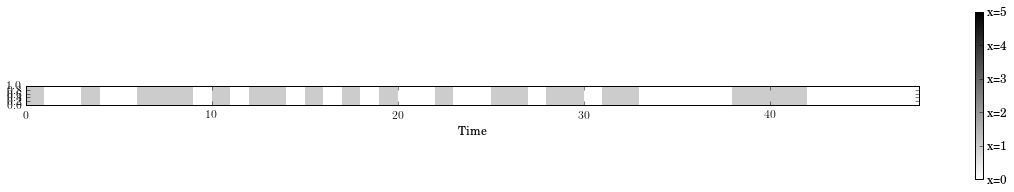

In [11]:
#%%debug 
#pumping_t.plot_results()
pumping_t.plot_results(name='Tariff_only_'+Time_step+'elevation'+str(h),save=True)

In [23]:
'30T' = 20070

ValueError: A valid traceback must be passed if no exception is being handled

In [24]:
results.groupby('h').mean()

day      schedule      cost_sim
h                                     
15T  175.0  24358.528605  1.460044e+06
30T  175.0  20493.807420  1.228075e+06
60T  175.0  15950.243210  9.457291e+05

24

In [ ]:
pumping_stoch.plot_results(name='day'+str(day)+'_T='+str(No_of_time_steps)+'_J='+str(J)+'init_fill_state'+str(h),save=True)


In [3]:
stoch_sched = [int(i[2]) for i in dec]
det_sched = [ int(i[2]) for i in  dec_forecast] #pumping.results['schedule'].values()]
ideal_sched = [ int(i[2]) for i in dec_ideal]#pumping_ideal.results['schedule'].values()]

#plt.pcolor([stoch_sched], vmin = 0, vmax = 5)
# plt.pcolormesh([stoch_sched]*5, vmin = 0, vmax = 5)
# cbar = plt.colorbar(ticks=range(6))
# cbar.set_ticklabels(decisions)
# plt.plot(range(25),fill_level_stoch_record,'b')
# plt.ylabel('Tank Level')
# plt.axis([0, No_of_time_steps, 0, tank.Hmax])
# plt.show()

# plt.pcolor([det_sched], vmin = 0, vmax = 5)
# #plt.pcolor([dec_forecast], vmin = 0, vmax = 5)
# cbar = plt.colorbar(ticks=range(6))
# cbar.set_ticklabels(decisions)
# plt.ylabel('Deterministic schedule')
# plt.show()

# plt.pcolor([ideal_sched], vmin = 0, vmax = 5)
# #plt.pcolor([dec_ideal], vmin = 0, vmax = 5)
# cbar = plt.colorbar(ticks=range(6))
# cbar.set_ticklabels(decisions)
# plt.ylabel('Ideal schedule')
# plt.show()

NameError: name 'dec' is not defined

In [4]:
actual_power = df.ix[int(No_of_time_steps*day):int(No_of_time_steps*day)+No_of_time_steps,:]['True Power']
forecasted_power = df.ix[int(No_of_time_steps*day):int(No_of_time_steps*day)+No_of_time_steps,:]['Forecasted Power']


fig, ax1 = plt.subplots(figsize=(15,3))
ax1.pcolormesh([stoch_sched]*tank.Hmax, vmin = 0, vmax = 5)
ax1.plot(range(len(stoch_sched)+1),fill_level_stoch_record,'b')
ax1.set_xlabel('Timestep')
ax1.axis([0, No_of_time_steps, 0, tank.Hmax])
ax1.set_ylabel('Tank level [m]', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
ax2.plot(np.array(range(No_of_time_steps))+0.5, actual_power,'r.',Markersize=15,label='True power')
ax2.plot(np.array(range(No_of_time_steps))+0.5, forecasted_power,'g.',Markersize=15,label='Forcasted power')
ax2.legend()
ax2.axis([0, No_of_time_steps, 0, turb.Power_rating])
ax2.set_ylabel('Wind Power [kW]', color='k')
for tl in ax2.get_yticklabels():
    tl.set_color('k')
plt.savefig('stoch_schedule.pdf',format='pdf')
plt.show()




fig, ax1 = plt.subplots(figsize=(15,3))
ax1.pcolormesh([det_sched]*tank.Hmax, vmin = 0, vmax = 5)
ax1.plot(range(No_of_time_steps+1),fill_level_forecast_record,'b')
ax1.set_xlabel('Timestep')
ax1.axis([0, No_of_time_steps, 0, tank.Hmax])
ax1.set_ylabel('Tank level [m]', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
ax2.plot(np.array(range(No_of_time_steps))+0.5, actual_power,'r.',Markersize=15,label='True power')
ax2.plot(np.array(range(No_of_time_steps))+0.5, forecasted_power,'g.',Markersize=15,label='Forcasted power')
ax2.legend()
ax2.axis([0, No_of_time_steps, 0, turb.Power_rating])
ax2.set_ylabel('Wind Power [kW]', color='k')
for tl in ax2.get_yticklabels():
    tl.set_color('k')
plt.savefig('Det_schedule.pdf',format='pdf')
plt.show()





fig, ax1 = plt.subplots(figsize=(15,3))
ax1.pcolormesh([ideal_sched]*tank.Hmax, vmin = 0, vmax = 5)
ax1.plot(range(No_of_time_steps+1),fill_level_ideal_record,'b')
ax1.set_xlabel('Timestep')
ax1.axis([0, No_of_time_steps, 0, tank.Hmax])
ax1.set_ylabel('Tank level [m]', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
ax2.plot(np.array(range(No_of_time_steps))+0.5, actual_power,'r.',Markersize=15,label='True power')
ax2.plot(np.array(range(No_of_time_steps))+0.5, forecasted_power,'g.',Markersize=15,label='Forcasted power')
ax2.legend()
ax2.axis([0, No_of_time_steps, 0, turb.Power_rating])
ax2.set_ylabel('Wind Power [kW]', color='k')
for tl in ax2.get_yticklabels():
    tl.set_color('k')
    
plt.savefig('Ideal_schedule.pdf',format='pdf')
plt.show()


NameError: name 'df' is not defined

In [731]:
print cost_ideal_sim,cost_det_sim, cost_stoch_sim

889937.407455 774031.424072 843093.601084


In [732]:
#1548782.82676 1399406.34635 1641185.24971


In [733]:
diff = [final_state_ideal-initial_fill_level , final_state_det-initial_fill_level ,final_state_stoch-initial_fill_level]

In [734]:
print diff

[0.29094371381495915, 1.1707021236279855, 2.108394110758645]


In [735]:
cost_stoch_sim/(base_demand*60*60*24)/100

0.0006505351860217652

In [725]:
diff_cost = tank.Area*np.array(diff)*1000*0.008 #cost_det_sim/(base_demand*60*60*24)

In [726]:
final  = np.array([cost_ideal_sim,cost_det_sim, cost_stoch_sim]) - diff_cost
print final 

[ 889206.18614833  771089.1287192   837794.62872482]


In [727]:
(np.sum(cost_ideal)-cost_ideal_sim)/cost_ideal_sim

0.9189749563029983